In [36]:
import numpy as np
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn import metrics

In [3]:
with h5.File('../qlk_jetexp_nn_training_database_minimal.h5', "r") as f:
    inputs = f['input']['block0_values'][()]
    input_names = f['input']['block0_items'][()]
    index_inp = f['input']['axis1'][()]   #row number from 0 to len(inputs)

    outputs = f['output']['block0_values'][()]
    output_names = f['output']['block0_items'][()]
    index_out = f['output']['axis1'][()]   #row number from 0 to len(inputs) with some missing rows

In [4]:
df_in = pd.DataFrame(inputs, index_inp, input_names)
df_out = pd.DataFrame(outputs, index_out, output_names)

Give a class label of 1 to inputs which have an output and 0 to inputs without a corresponding QuaLiKz output.

In [5]:
y = np.where(np.in1d(index_inp, index_out), 1, 0)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(df_in, y, test_size = 0.2, random_state = 42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [7]:
train_df = X_train
train_df['Target'] = y_train

valid_df = X_valid
valid_df['Target'] = y_valid

test_df = X_test
test_df['Target'] = y_test

train_df.to_pickle("./train_data.pkl")
valid_df.to_pickle("./validation_data.pkl")
test_df.to_pickle("./test_data.pkl")

In [35]:
train_data = pd.read_pickle("./train_data.pkl")
X_train, y_train = train_data.iloc[:, : -1].to_numpy(), train_data.iloc[:, -1].to_numpy()

validation_data = pd.read_pickle("./validation_data.pkl")
X_valid, y_valid = validation_data.iloc[:, : -1].to_numpy(), validation_data.iloc[:, -1].to_numpy()

test_data = pd.read_pickle("./test_data.pkl")
X_test, y_test = test_data.iloc[:, : -1].to_numpy(), test_data.iloc[:, -1].to_numpy()

In [37]:
scaler = StandardScaler()

scaler.fit(X_train)
scaler.fit(X_train)
scaler.transform(X_valid)
scaler.transform(X_test)

array([[-0.02655201, -0.34483678, -0.21996927, ..., -0.12259543,
        -0.08693051, -1.3025643 ],
       [-0.03970308,  0.36700906, -0.21996927, ..., -0.12814888,
        -0.08693051, -0.66269063],
       [-0.01090123, -0.08919354, -0.21996927, ..., -1.50555962,
        -0.08693051, -0.03155273],
       ...,
       [ 0.31205872, -0.2599409 ,  0.52726849, ..., -0.22799285,
        -1.66667635,  0.03588118],
       [-0.00409869, -0.18213573, -0.21996927, ...,  1.24037531,
        -0.08693051,  0.09789765],
       [ 0.00643201,  0.01521229, -0.21996927, ...,  1.31148725,
         0.32877127, -1.61544452]])

In [41]:
#scaler = StandardScaler()
#print(X_train)
#scaler.fit(X_train)
#scaler.transform(X_train)
#print(X_train)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer="Adam", loss = 'binary_crossentropy', metrics=["acc",tf.keras.metrics.AUC()])

Using first 10,000 points gives perfect classifier

In [42]:
#rdm_df = pd.DataFrame(X_train)
#rdm_series = pd.Series(y_train)

#rdm_sample = rdm_df.sample(100_000)
#rdm_y = rdm_series.sample(100_000)

#rdm_sample = rdm_sample.to_numpy()
#rdm_y = rdm_y.to_numpy()

y_train_tmp = pd.Series(y_train)
y_valid_tmp = pd.Series(y_valid)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, y_train_tmp, epochs = 10, 
                    validation_data = (X_valid, y_valid_tmp), validation_batch_size = 4096,
                    batch_size = 4096, callbacks = [callback] )


Epoch 1/10
6523/6523 [==============================] - 154s 23ms/step - loss: 0.4915 - acc: 0.7544 - auc_8: 0.8158 - val_loss: 0.3904 - val_acc: 0.8082 - val_auc_8: 0.8872
Epoch 2/10
6523/6523 [==============================] - 206s 32ms/step - loss: 0.3867 - acc: 0.8103 - auc_8: 0.8893 - val_loss: 0.3792 - val_acc: 0.8148 - val_auc_8: 0.8940
Epoch 3/10
6523/6523 [==============================] - 206s 32ms/step - loss: 0.3778 - acc: 0.8156 - auc_8: 0.8949 - val_loss: 0.3740 - val_acc: 0.8177 - val_auc_8: 0.8971
Epoch 4/10
6523/6523 [==============================] - 205s 31ms/step - loss: 0.3735 - acc: 0.8183 - auc_8: 0.8974 - val_loss: 0.3711 - val_acc: 0.8196 - val_auc_8: 0.8991
Epoch 5/10
6523/6523 [==============================] - 206s 32ms/step - loss: 0.3707 - acc: 0.8199 - auc_8: 0.8990 - val_loss: 0.3697 - val_acc: 0.8201 - val_auc_8: 0.8996
Epoch 6/10
6523/6523 [==============================] - 205s 32ms/step - loss: 0.3693 - acc: 0.8207 - auc_8: 0.8998 - val_loss: 0.3683 

In [43]:
#model.save("input_output_model")

INFO:tensorflow:Assets written to: input_output_model/assets


In [44]:
loss, accuracy, auc = model.evaluate(X_test,y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("AUC", auc)

104360/104360 [==============================] - 148s 1ms/step - loss: 0.3666 - acc: 0.8222 - auc_8: 0.9014
Loss:  0.36655938625335693
Accuracy:  0.82224440574646
AUC 0.9013649225234985


In [46]:
predicted = model.predict(X_test)
x = np.round(predicted).flatten()
diff = x - y_test
print(diff)


yes_out = X_test[np.where(x == 1)]
no_out = X_test[np.where(x == 0)]
 

[ 0. -1.  1. ...  1.  0.  1.]


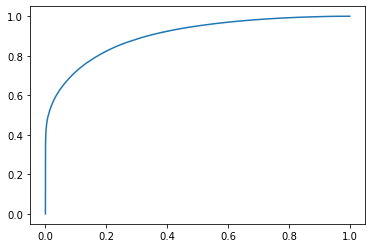

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)

plt.figure()

plt.plot(fpr,tpr)

In [48]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'acc', 'auc_8', 'val_loss', 'val_acc', 'val_auc_8'])

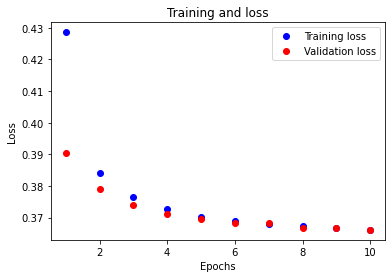

In [51]:
acc = history_dict['acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label = 'Validation loss' )
# b is for "solid blue line"
plt.title('Training and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
plt.hist([a,b])